# Introduction

____

<center><i>This notebook is part two of two, focused on training and testing a classification model. Please visit <a href='EDA.ipynb'>EDA.ipynb</a> for part one, where source data is loaded and explored and features are engineered. </center></i>

____

<img src='./images/equity_equality.jpg'>

<center> Equality vs. equity <br> <i> <a href="interactioninstitute.org">Interaction Institute for Social Change</a> // Angus Maguire</i> </center>

**SUMMARY**

The purpose of this report is to analyze health inequities in the US by county and how those inequities influence the degree of impact of the COVID-19 pandemic.

____

**STAKEHOLDERS**

Federal, state, and local governments and epidemiologists can use this analysis to shape public health policy and pandemic response plans. The goal is to learn from COVID-19 to prevent the loss that occurred in 2020-2021 from happening again.

____

**DATA SOURCES**

- [CDC’s Social Vulnerability Index](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html)

- [CDC's Vaccine Hesitancy](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw)

- [The University of Wisconsin Population Health Institute's County Health Rankings](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources) 

- [New York Times COVID Case and Death Counts](https://github.com/nytimes/covid-19-data)


____

**METHODS**

Classification model which predicts a given county’s degree of impact of the pandemic (high impact, average impact, low impact). Feature importance and coefficients will be analyzed to recommend what features put communities at greater risk in order to design policies to address the underlying issues.

____

**LOAD PACKAGES**

In [364]:
# style notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [365]:
#import standard packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#import viz packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

#import stats packages
import sklearn

#set random seed
rs=610
np.random.seed(rs)

# Data Load & Preprocessing

Data has been merged and partially preprocessed for modeling in the [EDA notebook.]('EDA.ipynb') We'll perform the following steps to ready the data for modeling:

- Load data
- Train-test split (80/20)
- Drop any non-encoded, non-continuous features
- Standard scale continuous features
- Address class imbalance in the training sample

____

**LOAD DATA**

Load in the saved csv from the EDA notebook and set "State" as the index.

In [366]:
df = pd.read_csv('./data/merged_state_level_dataset.csv', index_col='State')
df

,cases,deaths,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Hesitant or Strongly Vaccine Hesitant,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,SVI socioeconomic ranking,SVI household composition and disability ranking,SVI minority status and language ranking,SVI housing type and transportation ranking,SVI overall ranking,Premature death,Poor or fair health,Poor physical health days,Poor mental health days,Adult smoking,Adult obesity,Physical inactivity,Excessive drinking,Preventable hospital stays,Flu vaccinations,Life expectancy,Percent uninsured,Ratio of population to PCPs,Food environment index,Food insecurity,Homeownership,Broadband access,Income inequality,Air pollution,Drinking water violations,Percent rural,cases per 100k,deaths per 100k,Percent of cases resulting in death,impact_points,impact_category,impact_category_code,state_abbr
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HAWAII,36680,515.0,0.3260,0.0960,0.0047,0.2893,0.0134,0.1314,0.2623,0.0912,6422,1422029,539053,456782,221.42,35526.00,10.82,3.72,9.02,17.58,18.54,0.18,0.15,0.95,0.61,0.41,6185.0450,0.1613,3.6530,3.8644,0.1637,0.2460,0.1898,0.2339,2082.5000,0.4125,82.0065,0.0531,1230.7983,7.8500,0.1085,0.6204,0.8317,4.4691,6.9750,0.0000,0.1657,2579,36,1.404035,3873.7323,0-Low,0.0,HI
VERMONT,24433,258.0,0.1971,0.0181,0.0035,0.0099,0.0094,0.0004,0.9389,0.0620,9217,624977,333013,259589,67.80,31966.00,11.27,4.24,8.21,19.46,19.01,0.20,0.31,0.18,0.46,0.20,6774.5357,0.1393,3.8469,4.5565,0.1681,0.2828,0.2036,0.2158,3447.4286,0.4671,79.4099,0.0509,1539.0478,8.3429,0.1086,0.7435,0.8000,4.3180,5.4214,0.5000,0.7537,3909,41,1.055949,4344.1739,0-Low,0.0,VT
ALASKA,70774,360.0,0.7445,0.0531,0.3246,0.0539,0.0133,0.0053,0.4787,0.3743,570982,738516,315386,253462,1.29,32531.21,13.32,9.41,9.79,11.80,24.54,0.39,0.37,0.69,0.82,0.56,9636.3187,0.1984,4.7529,4.5961,0.2416,0.3309,0.2248,0.1910,3320.8333,0.2907,78.0253,0.1672,1297.5531,6.1400,0.1523,0.6499,0.7669,4.3408,8.1250,0.6000,0.6592,9583,48,0.508661,4996.5807,0-Low,0.0,AK
MAINE,69118,860.0,0.3119,0.0155,0.0081,0.0079,0.0084,0.0003,0.9400,0.1743,30844,1332813,739077,556955,43.21,28983.25,13.78,5.22,8.36,21.12,18.76,0.35,0.45,0.19,0.50,0.33,7381.4989,0.1720,4.2104,4.8363,0.2056,0.3087,0.2210,0.2138,3482.1250,0.4331,78.3590,0.1136,1185.7795,7.8375,0.1352,0.7466,0.7950,4.4482,6.4125,0.5625,0.7419,5185,64,1.244249,6849.5906,0-Low,0.0,ME
OREGON,209561,2812.0,0.5294,0.1210,0.0165,0.0168,0.0073,0.0033,0.8030,0.1977,95987,4081943,1750539,1591835,42.53,27690.11,15.25,6.82,11.11,21.07,20.75,0.51,0.56,0.58,0.70,0.60,6915.3168,0.1946,4.8098,5.0737,0.1941,0.3224,0.2132,0.2058,2634.1176,0.3968,79.1716,0.0911,1559.4675,7.4059,0.1308,0.6591,0.8149,4.3304,6.5618,0.6176,0.4110,5133,68,1.341853,7343.9600,0-Low,0.0,OR
UTAH,417330,2385.0,0.5072,0.0921,0.0285,0.0081,0.0046,0.0033,0.8484,0.1894,82195,3045350,1066131,957619,37.05,25467.79,11.87,4.01,8.29,14.18,29.50,0.35,0.30,0.55,0.33,0.32,6925.1158,0.1629,4.0783,4.1899,0.1228,0.2785,0.1923,0.1164,2674.2222,0.4189,79.2940,0.1145,2307.8994,7.2821,0.1267,0.7477,0.8348,3.8615,6.3571,0.6071,0.4651,13703,78,0.571490,8054.0112,0-Low,0.0,UT
WASHINGTON,455630,6011.0,0.4605,0.1445,0.0189,0.0275,0.0134,0.0032,0.7554,0.1346,66453,7294336,3064381,2800423,109.77,29278.85,14.24,6.07,11.25,19.66,21.67,0.44,0.48,0.66,0.57,0.52,6557.6389,0.1803,4.3815,4.4092,0.1584,0.3148,0.1942,0.1904,2685.4359,0.4023,79.9804,0.0901,1828.8292,7.4026,0.1285,0.6842,0.8280,4.3645,6.6282,0.3846,0.4479,6246,82,1.319272,8781.0759,0-Low,0.0,WA
NEW HAMPSHIRE,99626,1373.0,0.0970,0.0263,0.0019,0.0193,0.0113,0.0003,0.9227,0.1714,8953,1343622,630955,528078,150.07,35540.20,9.17,4.08,7.53,19.02,18.55,0.12,0.19,0.29,0.47,0.17,6744.0001,0.1408,3.67

____

**TRAIN-TEST SPLIT**

Before doing anything more with the data, need to create separate training and testing samples. This allows us to verify the performance of our models by predicting the targets of the test set, then comparing with the actual values.

Not all columns in the dataframe should be used as predictors since some of them were used to engineer the target feature. Case and death counts (both raw values and population-controlled) will be dropped, as well as the engineered percent of cases resulting in death. Impact points of course will also be removed.

In [367]:
# split the data into target (y) and predictors (X)
y = df['impact_category_code'].astype(int)
# drop columns I don't want to use as predictors
X = df.drop(columns=['impact_category_code', 'impact_category', 'impact_points',
                     'cases', 'deaths', 'cases per 100k', 'deaths per 100k', 
                     'Percent of cases resulting in death', 'state_abbr'
                    ])

In [368]:
#train-test split
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
print(f'X_train: {len(X_train)}')
print(f'y_train: {len(y_train)}')
print(f'X_test: {len(X_test)}')
print(f'y_test: {len(y_test)}')

X_train: 40
y_train: 40
X_test: 11
y_test: 11


In [369]:
display(X_train.head())
display(y_train)
display(X_test.head())
display(y_test)

,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Hesitant or Strongly Vaccine Hesitant,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,SVI socioeconomic ranking,SVI household composition and disability ranking,SVI minority status and language ranking,SVI housing type and transportation ranking,SVI overall ranking,Premature death,Poor or fair health,Poor physical health days,Poor mental health days,Adult smoking,Adult obesity,Physical inactivity,Excessive drinking,Preventable hospital stays,Flu vaccinations,Life expectancy,Percent uninsured,Ratio of population to PCPs,Food environment index,Food insecurity,Homeownership,Broadband access,Income inequality,Air pollution,Drinking water violations,Percent rural
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MICHIGAN,0.4002,0.0363,0.0135,0.0107,0.0382,0.0003,0.8775,0.1609,56602,9957488,4580939,3909509,175.92,26889.59,14.99,6.66,9.57,20.70,20.07,0.49,0.47,0.33,0.45,0.42,7606.3590,0.1895,4.6338,4.9356,0.2272,0.3408,0.2472,0.2111,3842.0000,0.4192,78.0957,0.0737,2381.2893,7.5732,0.1366,0.7792,0.7753,4.1640,7.1855,0.0964,0.6164
NEBRASKA,0.2368,0.0696,0.0125,0.0056,0.0093,0.0003,0.8891,0.1403,76817,1904760,830749,754063,24.80,28545.91,11.00,2.66,8.56,20.92,23.05,0.21,0.41,0.35,0.22,0.20,6794.0460,0.1475,3.3861,3.7421,0.1754,0.3533,0.2689,0.2304,3587.8354,0.3713,79.2348,0.1033,1885.4239,7.5937,0.1191,0.7302,0.7764,3.9799,6.0215,0.2405,0.7016
MINNESOTA,0.3309,0.0457,0.0191,0.0153,0.0177,0.0005,0.8821,0.1199,79625,5527358,2420473,2167801,69.42,30827.47,10.75,3.62,8.10,18.95,22.99,0.19,0.39,0.38,0.45,0.27,6207.2536,0.1434,3.5155,3.7648,0.1965,0.3300,0.2381,0.2315,5846.3448,0.4480,80.1733,0.0581,2121.5603,8.4747,0.0860,0.7681,0.7911,4.0491,6.3069,0.2069,0.6134
MASSACHUSETTS,0.0329,0.0930,0.0022,0.0404,0.0578,0.0004,0.7753,0.0800,7801,6830193,2882739,2601914,875.53,40222.43,10.69,5.21,8.56,17.64,19.43,0.22,0.17,0.70,0.55,0.33,6001.0654,0.1424,3.6816,4.5740,0.1615,0.2579,0.2004,0.2395,4429.5714,0.5464,80.4496,0.0344,1230.8058,8.7286,0.0848,0.6602,0.8543,5.0479,6.1786,0.3571,0.1675
LOUISIANA,0.7420,0.0367,0.0057,0.0084,0.3175,0.0002,0.6143,0.3067,43203,4663616,2045554,1736021,107.94,23582.08,22.00,7.56,18.38,15.53,23.58,0.76,0.67,0.63,0.72,0.79,10075.1504,0.2476,4.8599,5.2967,0.2534,0.3849,0.3035,0.1921,6456.4844,0.4009,75.5373,0.0927,3537.0466,6.6781,0.1654,0.6967,0.6909,5.6471,8.7187,0.7812,0.5109


State
MICHIGAN                1
NEBRASKA                1
MINNESOTA               1
MASSACHUSETTS           2
LOUISIANA               2
ARIZONA                 2
NORTH DAKOTA            1
ALASKA                  0
NEW HAMPSHIRE           0
SOUTH CAROLINA          1
OREGON                  0
WISCONSIN               1
NEW MEXICO              1
FLORIDA                 1
DISTRICT OF COLUMBIA    1
NEW YORK                1
NEVADA                  1
RHODE ISLAND            2
VIRGINIA                1
TENNESSEE               1
HAWAII                  0
NEW JERSEY              2
GEORGIA                 1
WYOMING                 1
OHIO                    1
ILLINOIS                1
SOUTH DAKOTA            2
OKLAHOMA                1
TEXAS                   1
MONTANA                 1
ARKANSAS                1
COLORADO                1
MARYLAND                1
WEST VIRGINIA           1
KANSAS                  1
INDIANA                 1
MISSISSIPPI             2
NORTH CAROLINA          1
MAINE 

,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Hesitant or Strongly Vaccine Hesitant,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,SVI socioeconomic ranking,SVI household composition and disability ranking,SVI minority status and language ranking,SVI housing type and transportation ranking,SVI overall ranking,Premature death,Poor or fair health,Poor physical health days,Poor mental health days,Adult smoking,Adult obesity,Physical inactivity,Excessive drinking,Preventable hospital stays,Flu vaccinations,Life expectancy,Percent uninsured,Ratio of population to PCPs,Food environment index,Food insecurity,Homeownership,Broadband access,Income inequality,Air pollution,Drinking water violations,Percent rural
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VERMONT,0.1971,0.0181,0.0035,0.0099,0.0094,0.0004,0.9389,0.0620,9217,624977,333013,259589,67.80,31966.00,11.27,4.24,8.21,19.46,19.01,0.20,0.31,0.18,0.46,0.20,6774.5357,0.1393,3.8469,4.5565,0.1681,0.2828,0.2036,0.2158,3447.4286,0.4671,79.4099,0.0509,1539.0478,8.3429,0.1086,0.7435,0.8000,4.3180,5.4214,0.5000,0.7537
UTAH,0.5072,0.0921,0.0285,0.0081,0.0046,0.0033,0.8484,0.1894,82195,3045350,1066131,957619,37.05,25467.79,11.87,4.01,8.29,14.18,29.50,0.35,0.30,0.55,0.33,0.32,6925.1158,0.1629,4.0783,4.1899,0.1228,0.2785,0.1923,0.1164,2674.2222,0.4189,79.2940,0.1145,2307.8994,7.2821,0.1267,0.7477,0.8348,3.8615,6.3571,0.6071,0.4651
WASHINGTON,0.4605,0.1445,0.0189,0.0275,0.0134,0.0032,0.7554,0.1346,66453,7294336,3064381,2800423,109.77,29278.85,14.24,6.07,11.25,19.66,21.67,0.44,0.48,0.66,0.57,0.52,6557.6389,0.1803,4.3815,4.4092,0.1584,0.3148,0.1942,0.1904,2685.4359,0.4023,79.9804,0.0901,1828.8292,7.4026,0.1285,0.6842,0.8280,4.3645,6.6282,0.3846,0.4479
IDAHO,0.3875,0.1308,0.0162,0.0065,0.0036,0.0011,0.8236,0.3177,82645,1687809,711731,618331,20.42,24397.14,14.98,4.93,11.86,18.11,25.26,0.49,0.50,0.53,0.35,0.45,7009.4652,0.1863,4.3467,4.4844,0.1877,0.3040,0.2338,0.1860,2467.3571,0.3742,79.2216,0.1512,2589.7857,7.5884,0.1163,0.7304,0.7968,4.0647,6.9070,0.5581,0.6057
DELAWARE,0.2000,0.0873,0.0035,0.0289,0.2049,0.0004,0.6466,0.0942,1948,949495,428251,357765,487.36,32643.33,12.23,5.70,11.23,19.03,21.33,0.35,0.36,0.80,0.61,0.50,8029.3712,0.1884,4.1500,4.4724,0.1905,0.3397,0.2883,0.1983,5079.0000,0.5567,78.3166,0.0732,1620.3991,8.2000,0.1137,0.7240,0.8430,4.2499,7.9667,0.3333,0.2429


State
VERMONT         0
UTAH            0
WASHINGTON      0
IDAHO           1
DELAWARE        1
PENNSYLVANIA    2
KENTUCKY        1
CONNECTICUT     2
IOWA            1
CALIFORNIA      1
ALABAMA         2
Name: impact_category_code, dtype: int64

____

**NORMALIZE**

All the predictors are continuous numeric values, so the next step is to normalize them around the z-distribution, which allows us to compare coefficients and feature importances which are naturally on different scales.

In [370]:
from sklearn.preprocessing import StandardScaler

In [371]:
scaler = StandardScaler()

In [372]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print('SCALED X_TRAIN:')
display(X_train_scaled.head())

print('\n')
print('*****'*10)
print('\n')

print('SCALED X_TEST:')
display(X_test_scaled.head())


SCALED X_TRAIN:


,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Hesitant or Strongly Vaccine Hesitant,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,SVI socioeconomic ranking,SVI household composition and disability ranking,SVI minority status and language ranking,SVI housing type and transportation ranking,SVI overall ranking,Premature death,Poor or fair health,Poor physical health days,Poor mental health days,Adult smoking,Adult obesity,Physical inactivity,Excessive drinking,Preventable hospital stays,Flu vaccinations,Life expectancy,Percent uninsured,Ratio of population to PCPs,Food environment index,Food insecurity,Homeownership,Broadband access,Income inequality,Air pollution,Drinking water violations,Percent rural
0,-0.231676,-0.583294,-0.263115,-0.272160,-0.427927,-0.181316,0.838392,-0.543735,-0.182085,0.669409,0.817242,0.779291,-0.171631,-0.396364,0.036311,0.519341,-0.709405,1.128793,-0.886874,0.196377,0.144417,-0.933182,-0.553752,-0.309550,-0.424447,-0.053022,0.611597,0.621723,0.653116,0.440695,-0.213546,0.463562,-0.477159,-0.192161,0.046747,-0.768886,0.069626,0.019552,0.370825,1.393468,0.116788,-0.767922,-0.068794,-1.425106,0.510431
1,-0.874470,-0.235806,-0.280148,-0.385769,-0.670466,-0.181316,0.906805,-0.781876,0.036142,-0.704358,-0.728047,-0.714465,-0.258570,-0.131044,-1.028976,-1.947835,-0.992355,1.233986,0.751870,-1.186909,-0.185680,-0.841016,-2.088245,-1.449318,-0.968501,-1.211372,-1.553274,-1.604162,-1.057918,0.769033,0.357489,1.128501,-0.727879,-1.057855,0.678514,-0.049347,-0.556945,0.046725,-0.274088,0.514167,0.137559,-1.102710,-0.885417,-0.826400,0.961887
2,-0.504293,-0.485204,-0.167731,-0.169689,-0.599971,-0.171522,0.865521,-1.017705,0.066456,-0.086356,-0.072991,-0.045216,-0.232900,0.234431,-1.095723,-1.355713,-1.121223,0.292030,0.718875,-1.285715,-0.295712,-0.702767,-0.553752,-1.086664,-1.361511,-1.324449,-1.328753,-1.561826,-0.360952,0.157011,-0.453013,1.166399,1.500025,0.328340,1.199024,-1.148103,-0.258565,1.214523,-1.493895,1.194279,0.415132,-0.976869,-0.685190,-0.966001,0.494535
3,-1.676587,0.008374,-0.455587,0.389444,-0.263436,-0.176419,0.235644,-1.478958,-0.708907,0.135903,0.117488,0.160289,0.230853,1.739377,-1.111743,-0.375011,-0.992355,-0.334346,-1.238819,-1.137506,-1.506067,0.771891,0.113419,-0.775819,-1.499607,-1.352029,-1.040555,-0.052663,-1.517056,-1.736841,-1.445088,1.442022,0.102450,2.106719,1.352265,-1.724221,-1.384113,1.551077,-1.538118,-0.741977,1.608508,0.839462,-0.775200,-0.341950,-1.868190
4,1.112922,-0.579120,-0.395972,-0.323395,1.916062,-0.186214,-0.713891,1.141746,-0.326731,-0.233707,-0.227479,-0.249616,-0.210740,-0.926182,1.907905,1.074455,1.758700,-1.343243,1.043324,1.530261,1.244741,0.449310,1.247610,1.607331,1.229048,1.549362,1.003901,1.295177,1.518542,1.599071,1.267988,-0.191041,2.101896,-0.522896,-1.372190,-0.307020,1.530029,-1.166937,1.432168,-0.086988,-1.476897,1.929115,1.006847,1.420099,-0.048590




**************************************************


SCALED X_TEST:


,CVAC level of concern for vaccination rollout,Percent Hispanic,Percent American Indian Alaska Native,Percent Asian,Percent Black,Percent Native Hawaiian Pacific Islander,Percent White,% Hesitant or Strongly Vaccine Hesitant,AREA_SQMI,population,housing units count,households count,population density (pop per sqmi),per capita income,poverty rate,unemployment rate,% adults without hs diploma,% population >65,% population <17,SVI socioeconomic ranking,SVI household composition and disability ranking,SVI minority status and language ranking,SVI housing type and transportation ranking,SVI overall ranking,Premature death,Poor or fair health,Poor physical health days,Poor mental health days,Adult smoking,Adult obesity,Physical inactivity,Excessive drinking,Preventable hospital stays,Flu vaccinations,Life expectancy,Percent uninsured,Ratio of population to PCPs,Food environment index,Food insecurity,Homeownership,Broadband access,Income inequality,Air pollution,Drinking water violations,Percent rural
0,-1.030645,-0.773212,-0.433444,-0.289981,-0.669627,-0.176419,1.200512,-1.687042,-0.693621,-0.922684,-0.933142,-0.948544,-0.233832,0.416809,-0.956889,-0.973301,-1.090407,0.535887,-1.469782,-1.236312,-0.735841,-1.624428,-0.487035,-1.449318,-0.981568,-1.437526,-0.753745,-0.085301,-1.299048,-1.082792,-1.360880,0.625490,-0.866383,0.673534,0.775628,-1.323126,-0.994622,1.039818,-0.661036,0.752834,0.583187,-0.487871,-1.306426,0.251770,1.237953
1,0.189249,-0.001017,-0.007622,-0.330078,-0.709911,-0.034402,0.666768,-0.214269,0.094200,-0.509777,-0.631056,-0.618104,-0.251523,-0.624117,-0.796696,-1.115164,-1.067995,-1.988746,4.298815,-0.495266,-0.790857,0.080645,-1.354357,-0.827626,-0.880716,-0.786644,-0.352245,-0.769012,-2.795376,-1.195741,-1.658239,-2.799117,-1.629112,-0.197583,0.711347,0.222911,-0.023109,-0.366312,0.005988,0.828203,1.240299,-1.318022,-0.649971,0.696749,-0.291274
2,0.005537,0.545780,-0.171138,0.102081,-0.636058,-0.039300,0.118279,-0.847770,-0.075740,0.215085,0.192335,0.254261,-0.209687,-0.013637,-0.163931,0.155432,-0.238756,0.631517,-0.007011,-0.050638,0.199434,0.587559,0.246853,0.208526,-1.126837,-0.306756,0.173834,-0.360016,-1.619454,-0.242248,-1.608241,-0.249610,-1.618050,-0.497594,1.092038,-0.370222,-0.628457,-0.206585,0.072322,-0.311299,1.111897,-0.403310,-0.459776,-0.227693,-0.382413
3,-0.281636,0.402819,-0.217127,-0.365720,-0.718303,-0.142139,0.520504,1.268909,0.099058,-0.741369,-0.777089,-0.778720,-0.261090,-0.795621,0.033641,-0.547713,-0.067866,-0.109616,1.967180,0.196377,0.309466,-0.011521,-1.220923,-0.154128,-0.824222,-0.141277,0.113453,-0.219768,-0.651630,-0.525931,-0.566167,-0.401203,-1.833174,-1.005444,0.671193,1.115043,0.333080,0.039700,-0.377274,0.517756,0.522763,-0.948500,-0.264180,0.493164,0.453734
4,-1.019237,-0.051106,-0.433444,0.133268,0.971081,-0.176419,-0.523394,-1.314803,-0.772092,-0.867323,-0.893898,-0.902069,0.007540,0.525308,-0.700580,-0.072782,-0.244359,0.330282,-0.193982,-0.495266,-0.460760,1.232722,0.513722,0.104910,-0.141131,-0.083360,-0.227839,-0.242148,-0.559141,0.411801,0.868000,0.022567,0.743078,2.292871,0.169263,-0.781041,-0.891827,0.850398,-0.473090,0.402908,1.395135,-0.611711,0.479269,-0.440834,-1.468662


___

**BALANCE CLASSES**

In order for our model to effectively learn all three of our classes, we need to train it on a balanced set comprised of equal observations in each class. 

In [373]:
# checking for class imbalance in the target feature
print(y_train.value_counts())
print('*****'*15)
print(y_train.value_counts(normalize=True).round(3))

1    28
2     7
0     5
Name: impact_category_code, dtype: int64
***************************************************************************
1    0.700
2    0.175
0    0.125
Name: impact_category_code, dtype: float64


In [374]:
from imblearn.over_sampling import SMOTE

In [375]:
#balance classes using SMOTE, which accepts all continuous values
smote = SMOTE(sampling_strategy='all', random_state=rs, n_jobs=5, k_neighbors=1)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

#validate class balance
print(y_train_bal.value_counts())
print('*****'*15)
print(y_train_bal.value_counts(normalize=True).round(3))

2    28
1    28
0    28
Name: impact_category_code, dtype: int64
***************************************************************************
2    0.333
1    0.333
0    0.333
Name: impact_category_code, dtype: float64


Reset variables to make the modeling workflow easier

In [376]:
#reset variables 
X_train = X_train_bal
y_train = y_train_bal
X_test = X_test_scaled
y_test = y_test

# Multi-Class Classification Problem 

The engineered target feature - Pandemic Impact Category - has three possible values: 0-Low, 1-Average, or 2-High. This means we have a multi-class classification problem.

___

**APPROACHES** 

1. **Multiclass regressors** - some of scikit learn's various algorithms inherently support multiclass problems, including:
    - Tree-based models (decision tree, bagged trees, random forest)
    - K-Nearest Neighbors
    - Logistic Regression with `multi_class='multinomial'`
    - Ridge classifier<br>
<br>
2. **Meta-classifiers** - fit "n" base binary classifiers which predict class membership probability.

    - **One vs Rest (OVR)** - one binary classification for each class vs the other classes, where the model with the highest probability score is used to predict the class of a new observation `n = number of classes`. <br>Automatically used by:
        - Gradient Boost Classifier
        - linear Support Vector Machines
        - Logistic Regression with `multi_class='ovr'`
        - Perceptron sklearn algorithms
        - can be used with any other base classifier

    - **One vs One (OVO)** - one binary classification for each pair of classes, where each new observation's class is predicted based on the majority vote amongst the n-models `n = 0.5* (n_classes* (n_classes - 1)))`. <br>Automatically used by:
        - Support Vector Machines
        - can be used with any other base classifier

____


**EVALUATION METRICS**

- **Overfitting** - the difference between the accuracy score on the training data and the accuracy score on the testing data.<br>*Lower numbers are better, as they indicate the model is not too overfit on the training data and is extensible to new observations.*

- **Accuracy** - measure of how many predictions the model gets right<br>*Higher numbers are desirable*

- **AUC** - an alternative measure of model accuracy<br>*Higher numbers are desirable*

- **F1 Score** - represents the harmonic mean of precision (how many predicted positives are true positives) and recall (how many actual positives were correctly predicted)<br>*Higher numbers are desirable.*

Metrics for my multiclass models could be calculated as either: 
- Macro-average - computes the metric independently for each class then takes the average <br> 
- Micro-average - aggregates the contributions of all classes, then calculates the metric. 

The micro-average is a way to take a weighted average, but because I know my classes are balanced, I can safely use the macro-average.


## Functions

In [377]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [378]:
def evaluate_multiclass_regressor(model, X_train, y_train, X_test, y_test, cmap='Blues',
                                  track=True, stats_df=None, name=None):
    #fit model
    model.fit(X_train, y_train)
    
    #generate class preditions
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    
    #calculate accuracy
    test_acc = sklearn.metrics.accuracy_score(y_test, y_test_preds, normalize=True)
    train_acc = sklearn.metrics.accuracy_score(y_train, y_train_preds, normalize=True)
    
    #check for overfitting
    overfit = train_acc - test_acc
    
    #calculate ROC AUC
    auc = sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    
    #calculate F1 score
    f1 = sklearn.metrics.f1_score(y_test, y_test_preds, average='macro')
    
    print('----CLASSIFICATION REPORT----')
    print(classification_report(y_test, y_test_preds, target_names=['0-Low', '1-Average', '2-High']))
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true',
                          display_labels=['0-Low', '1-Average', '2-High'])
    
    #instantiate df if not passed
    if stats_df is None:
        stats_df = pd.DataFrame(columns=['Model Name', 'Overfit Check', 'Accuracy', 'AUC', 'F1 Score'])

    #collect metrics in a dictionary    
    stats_dict = {}
    stats_dict['Model Name'] = name
    stats_dict['Overfit Check'] = overfit
    stats_dict['Accuracy'] = test_acc
    stats_dict['AUC'] = auc
    stats_dict['F1 Score'] = f1    
    
    #if set to track results of this model for aggregation, append dict to stats_df
    if track == True:
        stats_df = stats_df.append(pd.Series(stats_dict), ignore_index=True)
        return stats_df

In [379]:
#initialize a df to collect metrics across multiple models
model_eval_df = pd.DataFrame(columns=['Model Name', 'Overfit Check', 'Accuracy', 'AUC', 'F1 Score'])

## Approach 1: Multiclass Regressors

Some of scikit learn's various algorithms inherently support multiclass problems, including:
- Tree-based models (decision tree, random forest)
- K-Nearest Neighbors
- Logistic Regression with `multi_class='multinomial'`


### Tree-based models

In [380]:
from sklearn.tree import DecisionTreeClassifier
mr_dt = DecisionTreeClassifier(random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.6125,0.505128


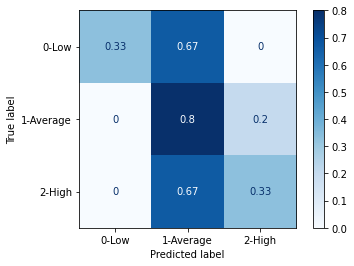

In [381]:
model_eval_df = evaluate_multiclass_regressor(mr_dt, X_train, y_train, X_test, y_test, 
                                              stats_df=model_eval_df,
                                              name='Multiclass regressor decision tree default params')
model_eval_df

In [382]:
# create a dictionary with the values for each parameter in the decision tree to optimize
dt_param_grid = {'criterion': ['entropy', 'gini'],
                'max_depth': [None, 5, 10, 15],
                'min_samples_leaf': [1, 2, 3],
                'max_features': [None, 3, 5, 8, 10]}

In [383]:
from sklearn.model_selection import GridSearchCV

In [384]:
dt_gridsearch = GridSearchCV(mr_dt, dt_param_grid, cv=3, return_train_score=True)

In [385]:
param = dt_gridsearch.fit(X_train, y_train).best_params_
param

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1}

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.6125,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.6125,0.505128


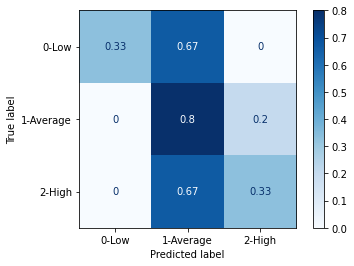

In [386]:
model_eval_df = evaluate_multiclass_regressor(dt_gridsearch, X_train, y_train, X_test, y_test,
                                              name='Multiclass regressor grid search', 
                                              stats_df=model_eval_df)
model_eval_df

In [387]:
from sklearn.ensemble import RandomForestClassifier

In [388]:
mr_rf = RandomForestClassifier(criterion=param['criterion'], 
                               max_depth=param['max_depth'], 
                               max_features=param['max_features'], 
                               min_samples_leaf=param['min_samples_leaf'],
                               random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128


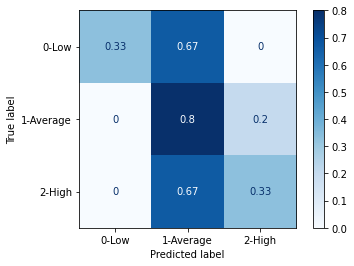

In [389]:
model_eval_df = evaluate_multiclass_regressor(mr_rf, X_train, y_train, X_test, y_test,
                                             stats_df=model_eval_df,
                                             name='Multiclass Regressor random forest with grid search params')
model_eval_df

In [390]:
model_eval_df

,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128


### Nearest Neighbors

In [391]:
from sklearn.neighbors import KNeighborsClassifier

In [392]:
best_k = 0
best_score = 0.0
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, preds)
    if acc > best_score:
        best_k = k
        best_score = acc
        
print(f'Best K: {best_k}')
print(f'Accuracy Score: {best_score}')

Best K: 1
Accuracy Score: 0.8181818181818182


In [393]:
mr_knn = KNeighborsClassifier(n_neighbors=best_k)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.67      0.80         3
   1-Average       0.71      1.00      0.83         5
      2-High       1.00      0.67      0.80         3

    accuracy                           0.82        11
   macro avg       0.90      0.78      0.81        11
weighted avg       0.87      0.82      0.82        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111


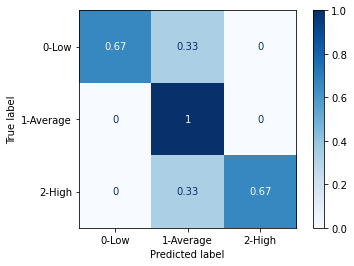

In [394]:
model_eval_df = evaluate_multiclass_regressor(mr_knn, X_train, y_train, X_test, y_test,
                                             stats_df=model_eval_df, 
                                             name='Multiclass regressor k-nearest neighbors k=1')
model_eval_df

The KNN algorithm using k=1 is performing best, especially at predicting 2-High pandemic impact.

### Logistic Regression

In [395]:
from sklearn.linear_model import LogisticRegressionCV

In [396]:
mr_lr = LogisticRegressionCV(multi_class='multinomial', cv=10, n_jobs=3, random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128


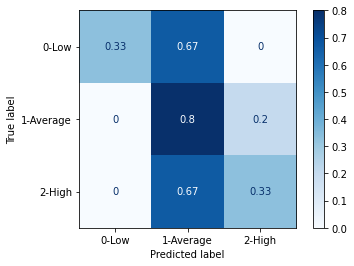

In [397]:
mr_lr_name = 'Multiclass regressor Logistic Regression with 3x 10-fold cross-validation'

model_eval_df = evaluate_multiclass_regressor(mr_lr, X_train, y_train, X_test, y_test,
                                              stats_df=model_eval_df, name=mr_lr_name)
model_eval_df

## Approach 2a - One-vs-Rest (OVR) Meta-Classifier

Fits "n" base binary classifiers, one for each class, which predicts each target class against the others. The model with the highest probability score is used to predict the class of a new observation. 

`n = number of classes`

Automatically used by:
* Gradient Boost Classifier
* linear Support Vector Machines
* Logistic Regression with `multi_class='ovr'`
* Perceptron


### Gradient Boost

In [398]:
from sklearn.ensemble import GradientBoostingClassifier

In [399]:
ovr_gb = GradientBoostingClassifier(random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128


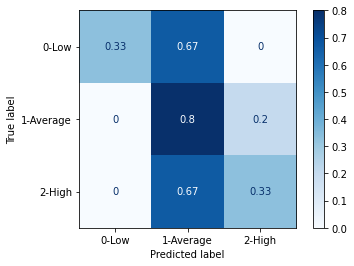

In [400]:
ovr_gb_name = 'OVR Gradient Boost'
model_eval_df = evaluate_multiclass_regressor(ovr_gb, X_train, y_train, X_test, y_test, 
                                              stats_df=model_eval_df, name=ovr_gb_name)
model_eval_df                                              

In [401]:
# use best params from decision tree grid search
ovr_gb2 = GradientBoostingClassifier(max_depth=param['max_depth'], 
                                     max_features=param['max_features'], 
                                     min_samples_leaf=param['min_samples_leaf'], 
                                     random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       0.50      0.67      0.57         3
   1-Average       0.60      0.60      0.60         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.53      0.53      0.52        11
weighted avg       0.55      0.55      0.54        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128
6,OVR Gradient Boost with grid searched params,0.454545,0.545455,0.604167,0.523810


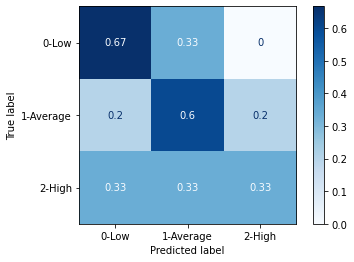

In [402]:
ovr_gb2_name = 'OVR Gradient Boost with grid searched params'
model_eval_df = evaluate_multiclass_regressor(ovr_gb2, X_train, y_train, X_test, y_test,
                                              stats_df=model_eval_df, name=ovr_gb2_name)
model_eval_df

### Linear Support Vector Machine

In [403]:
from sklearn.svm import SVC

In [404]:
ovr_svc_linear = SVC(kernel='linear', probability=True, random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128
6,OVR Gradient Boost with grid searched params,0.454545,0.545455,0.604167,0.523810
7,OVR SVC linear,0.454545,0.545455,0.752778,0.505128


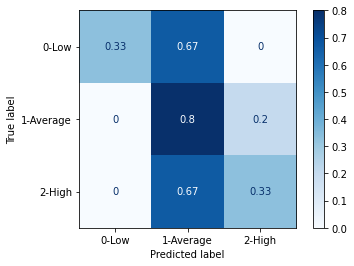

In [405]:
model_eval_df = evaluate_multiclass_regressor(ovr_svc_linear, X_train, y_train, X_test, y_test,
                                              stats_df=model_eval_df, name='OVR SVC linear')
model_eval_df

### Logistic Regression OVR

In [406]:
ovr_lr = LogisticRegressionCV(multi_class='ovr', cv=10, n_jobs=3, random_state=rs)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.50      0.80      0.62         5
      2-High       0.50      0.33      0.40         3

    accuracy                           0.55        11
   macro avg       0.67      0.49      0.51        11
weighted avg       0.64      0.55      0.53        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128
6,OVR Gradient Boost with grid searched params,0.454545,0.545455,0.604167,0.523810
7,OVR SVC linear,0.454545,0.545455,0.752778,0.505128
8,OVR Logistic Regression,0.454545,0.545455,0.719444,0.505128


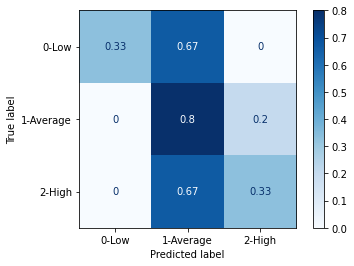

In [407]:
model_eval_df = evaluate_multiclass_regressor(ovr_lr, X_train, y_train, X_test, y_test,
                                              stats_df=model_eval_df, name='OVR Logistic Regression')
model_eval_df

## Approach 2b - One-vs-One

One binary classification is fit for each pair of classes, where each new observation's class is predicted based on the majority vote amongst the n-models 

`n = 0.5* (n_classes* (n_classes - 1)))`

Automatically used by Support Vector Machines.

In [408]:
ovo_svm = SVC(random_state=rs, probability=True)

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.33      0.50         3
   1-Average       0.56      1.00      0.71         5
      2-High       1.00      0.33      0.50         3

    accuracy                           0.64        11
   macro avg       0.85      0.56      0.57        11
weighted avg       0.80      0.64      0.60        11



,Model Name,Overfit Check,Accuracy,AUC,F1 Score
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128
6,OVR Gradient Boost with grid searched params,0.454545,0.545455,0.604167,0.523810
7,OVR SVC linear,0.454545,0.545455,0.752778,0.505128
8,OVR Logistic Regression,0.454545,0.545455,0.719444,0.505128
9,OVO Support Vector Machine,0.351732,0.636364,0.794444,0.571429


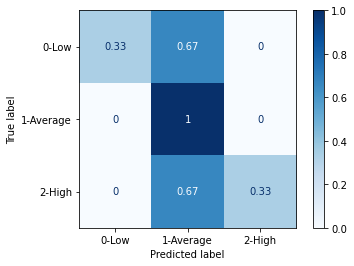

In [409]:
model_eval_df = evaluate_multiclass_regressor(ovo_svm, X_train, y_train, X_test, y_test,
                                              stats_df=model_eval_df,
                                              name='OVO Support Vector Machine')
model_eval_df

## Interpretation

In [410]:
model_eval_df.sort_values('Accuracy', ascending=False)

,Model Name,Overfit Check,Accuracy,AUC,F1 Score
3,Multiclass regressor k-nearest neighbors k=1,0.181818,0.818182,0.833333,0.811111
9,OVO Support Vector Machine,0.351732,0.636364,0.794444,0.571429
0,Multiclass regressor decision tree default params,0.454545,0.545455,0.612500,0.505128
1,Multiclass regressor grid search,0.454545,0.545455,0.612500,0.505128
2,Multiclass Regressor random forest with grid s...,0.454545,0.545455,0.736111,0.505128
4,Multiclass regressor Logistic Regression with ...,0.454545,0.545455,0.777778,0.505128
5,OVR Gradient Boost,0.454545,0.545455,0.608333,0.505128
6,OVR Gradient Boost with grid searched params,0.454545,0.545455,0.604167,0.523810
7,OVR SVC linear,0.454545,0.545455,0.752778,0.505128
8,OVR Logistic Regression,0.454545,0.545455,0.719444,0.505128


The **k-nearest neighbors with k=1** stands out as the best performing model. 

I'll use permutation feature importance to explore the model by its feature importances. Each feature is dropped from the predictor set, the model is rerun, and importance is calculated by how much the given scoring metric changed. I'll use both Accuracy and F1 score as scoring metrics.

In [432]:
from sklearn.inspection import permutation_importance

In [433]:
def permutation_feature_importance(model, X_test, y_test, random_state=rs):
    
    r_acc = permutation_importance(model, X_test, y_test, random_state=random_state, scoring='accuracy')
    r_f1 = permutation_importance(model, X_test, y_test, random_state=random_state, scoring='f1_macro')
    
    sorted_acc = r_acc.importances_mean.argsort()
    sorted_f1 = r_f1.importances_mean.argsort()
    
    feats_acc = pd.DataFrame(dict(zip(X_test.columns, r_acc.importances_mean)), index=['Accuracy']).T
    feats_f1 = pd.DataFrame(dict(zip(X_test.columns, r_f1.importances_mean)), index=['F1 Score']).T
    
    feat_imp = pd.concat([feats_acc, feats_f1], axis=1).sort_values('Accuracy')
    feat_imp = feat_imp[(feat_imp['Accuracy'] != np.nan) & (feat_imp['F1 Score'] != np.nan) & 
                        (feat_imp['Accuracy'] > 0) & (feat_imp['F1 Score'] >0)]
    
    return feat_imp

def plot_permutation_feature(feat_imp, 
                             title='', labels={}, 
                             color_discrete_sequence=['rebeccapurple', 'cornflowerblue'],
                             facet_row_spacing=.5, figheight=750, legendx=.52, legendy=.01):
    
    fig = px.bar(feat_imp, orientation='h', title='KNN Feature Importances',
             labels={'variable': 'Feature Importance Scoring Method', 
                     'feat_importance_accuracy': 'Accuracy',
                     'feat_importance_f1': 'F1 Score',
                     'index': 'Feature',
                     'value': 'Importance'},
             color_discrete_sequence=['rebeccapurple', 'cornflowerblue'],
             facet_row_spacing=.5)
    fig.update_layout(height=figheight, bargap=.4,
                      yaxis=dict(tickfont_size=10),
                      legend=dict(x=legendx,
                                  y=legendy),
                      barmode='group')
    fig.show()

----CLASSIFICATION REPORT----
              precision    recall  f1-score   support

       0-Low       1.00      0.67      0.80         3
   1-Average       0.71      1.00      0.83         5
      2-High       1.00      0.67      0.80         3

    accuracy                           0.82        11
   macro avg       0.90      0.78      0.81        11
weighted avg       0.87      0.82      0.82        11



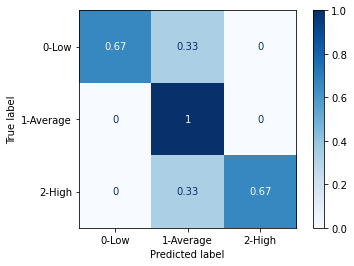

In [434]:
#rerun evaluation function
evaluate_multiclass_regressor(mr_knn, X_train, y_train, X_test, y_test, track=False)

While sometimes incorrectly predicting average impact, the k-nearest neighbors model overall performs with 82% accuracy.

In [435]:
mr_knn_feat_imp = permutation_feature_importance(mr_knn, X_test, y_test)
plot_permutation_feature(mr_knn_feat_imp, title='KNN Feature Importances')

Features most important to determining the prediction are:
- Poverty rate
- Income inequality
- Education (% of adults without high school diploma)
- Unemployment rate
- Food insecurity

For the KNN model, I'd like to visualize the decision boundary. In order to do this, I would first need to condense the feature set down to 2 dimensions using principal component analysis. Depending on how well PCA captures the variance in the predictor set, I'll decide whether to run a new model on the condensed feature set.

#### Principal Component Analysis

In [415]:
from sklearn.decomposition import PCA

In [436]:
#scale original predictor set
X_scale = scaler.fit_transform(X)
#initialize PCA to 2 dimensions
pca = PCA(n_components=2, random_state=rs)
X_pca = pca.fit_transform(X_scale)
X_pca

array([[-6.69093579,  4.54453367],
       [-4.7439685 , -2.45750948],
       [ 2.5962084 ,  2.33021251],
       [-1.88001221, -2.40034147],
       [-0.32342117,  0.73005904],
       [-2.30360895, -1.32983108],
       [-1.69196943,  0.80162586],
       [-5.70089461, -1.64862642],
       [-3.78028538,  0.3560047 ],
       [-0.2942156 , -1.84209575],
       [-2.82773646, -2.21297435],
       [-3.31785805, -3.89182225],
       [ 3.27327342,  0.77967735],
       [ 0.06180733, -0.21658165],
       [-3.88493617, -2.69664524],
       [-3.74227708, -2.65723822],
       [-1.58974455, -3.15631249],
       [ 4.83486368, -2.3284624 ],
       [-0.86265885,  5.81311166],
       [ 6.22075396, -1.62289516],
       [ 3.29362205, -2.23272783],
       [-3.09751822,  0.60325907],
       [-4.44801944, 11.51881195],
       [ 1.08957194, -1.67938414],
       [-1.76459597,  0.87658799],
       [-0.43271715, -2.85623935],
       [ 2.95095373,  1.70745284],
       [ 5.22376423, -1.50063148],
       [ 5.2088273 ,

In [437]:
print('Variance of each component:', pca.explained_variance_ratio_)
print('\nTotal Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [0.38295293 0.17116516]

Total Variance Explained: 55.41


Because the condensed features only explain a little over half of the variance, I will not move forward.

# Conclusion & Recommendations

Based on learnings from COVID-19, a KNN model can predict the level of impact (high, average, low) a US state will experience in the case of another pandemic.

Poverty rate, income inequality, education (% of adults without high school diploma), unemployment rate, and food insecurity are the top five features needed to make such predictions.

<img src='./images/scatter_poverty rate.jpg' align=left style="width: 450px;">
<img src='./images/boxplot_poverty rate_impactcat.jpg' align=right style="width: 450px;">

<img src='./images/scatter_Income inequality.jpg' align=left style="width: 450px">
<img src='./images/boxplot_Income inequality_impactcat.jpg' align=right style="width: 450px">

<img src='./images/scatter_% adults without hs diploma.jpg' align=left style="width: 450px;">
<img src='./images/boxplot_% adults without hs diploma_impactcat.jpg' align=right style="width: 450px;">

<img src='./images/scatter_unemployment rate.jpg' align=left style="width: 450px">
<img src='./images/boxplot_unemployment rate_impactcat.jpg' align=right style="width: 450px">

<img src='./images/scatter_Food insecurity.jpg' align=left style="width: 450px">
<img src='./images/boxplot_Food insecurity_impactcat.jpg' align=right style="width: 450px">

**RECOMMENDATIONS:**

- States should have accurate, frequent measurement plans in place for each of the features shown here to increase their community's vulnerability to extensive spread of illness and mortality. What you measure, you can manage!

- When planning public health budgets, consider what social determinants - unemployment, education, income inequality, etc. - may play a role in health outcomes and could be invested in with dollars allocated to "health."

- In the case of a pandemic, the federal government should be able to allocate emergency funds according to vulnerability in order to slow the spread of illness and limit unnecessary deaths.

# Future Enhancements

- Rerun models with a slimmer feature set
- Analyze at the county level with updated county-level case and death counts
- Incorporate ICU/hospital capacity in impact calculation

# Appendix

## Binarize target preprocessing steps

1. Binarize target
1. Train-test split
1. Normalize
1. Balance classes in training set

In [422]:
#binarize target
y_bin = sklearn.preprocessing.label_binarize(y, classes=[0,1,2])
#save n_classes as variable
n_classes = y_bin.shape[1]
print(n_classes)
y

3


State
HAWAII                  0
VERMONT                 0
ALASKA                  0
MAINE                   0
OREGON                  0
UTAH                    0
WASHINGTON              0
NEW HAMPSHIRE           0
COLORADO                1
IDAHO                   1
WYOMING                 1
NEBRASKA                1
NORTH CAROLINA          1
VIRGINIA                1
MINNESOTA               1
WISCONSIN               1
MONTANA                 1
WEST VIRGINIA           1
CALIFORNIA              1
KENTUCKY                1
MISSOURI                1
MARYLAND                1
DISTRICT OF COLUMBIA    1
OHIO                    1
DELAWARE                1
KANSAS                  1
FLORIDA                 1
TENNESSEE               1
OKLAHOMA                1
TEXAS                   1
NEVADA                  1
IOWA                    1
ARKANSAS                1
SOUTH CAROLINA          1
ILLINOIS                1
GEORGIA                 1
NORTH DAKOTA            1
INDIANA                 1
NEW ME

In [423]:
#re-do train-test split with binarized target
X2_train , X2_test, y2_train, y2_test = train_test_split(X, y_bin, test_size=0.2, random_state=rs)

In [424]:
#re-scale
X2_train_scaled = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2_train.columns)
X2_test_scaled = pd.DataFrame(scaler.transform(X2_test), columns=X2_test.columns)

In [425]:
#re-balance
smote = SMOTE(sampling_strategy='all', random_state=rs, n_jobs=5, k_neighbors=3)
X2_train_bal, y2_train_bal = smote.fit_resample(X2_train_scaled, y2_train)

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error



In [426]:
#validate class balance
sum_low = 0
sum_avg = 0
sum_high = 0
for e in range(len(y2_train_bal)):
    sum_low += y2_train_bal[e][0]
    sum_avg += y2_train_bal[e][1]
    sum_high += y2_train_bal[e][2]
print(sum_low, sum_avg, sum_high)

28 28 28


In [427]:
#reset variables
X2_train = X2_train_bal
y2_train = y2_train_bal
X2_test = X2_test_scaled
y2_test = y_test

In [428]:
len(y2_test.unique())

3

## Functions - Plot ROC curve and evaluate models with binarized target

In [429]:
def plot_roc_metaclassifier(fit_model, X_test, y_test):
    #save n_classes for ease
    n_classes = len(y_test.unique())
    
    y_score = fit_model.decision_function(X_test)

    #initialize dictionaries to save metrics
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    #calculate fpr, tpr, and roc_auc for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #calculate and save the micro average AUC for all classes
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    #calculate and save macro average fpr, tpr, and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    fpr['macro'] = all_fpr
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    #plot figure with averages and class-specific ROC curves
    sns.set_style('dark')
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Receiver Operating Characteristic (ROC) Curves')
    fig.set_figwidth(12)
    fig.set_figheight(6)
    #ax1 - averages
    ax1.set_title('Micro and Macro Averages')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot([0, 1], [0, 1], color='darkslategray', ls='--')
    ax1.plot(fpr["micro"], tpr["micro"], color='deeppink',
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    ax1.plot(fpr["macro"], tpr["macro"], color='teal',
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    ax1.legend(loc='lower right')
    #ax2 = class curves
    ax2.set_title('ROC Curves by Class')
    ax2.plot([0, 1], [0, 1], color='darkslategray', ls='--')
    from itertools import cycle
    colors = cycle(['darkslateblue', 'gold', 'brown'])
    for i, color in zip(range(n_classes), colors):
        ax2.plot(fpr[i], tpr[i], color=color, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    ax2.legend(loc='lower right')
    ax2.set_xlabel('False Positive Rate')

    fig.tight_layout()
    fig.show()
    
    return roc_auc

In [430]:
def evaluate_metaclassifier(model, X_train, y_train, X_test, y_test,
                              stats_df=None, name=None, track=True):
    #fit model on training set
    model.fit(X_train, y_train)
    
    #generate class preditions
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    
    #calculate accuracy
    test_acc = accuracy_score(y_test, y_test_preds, normalize=True, )
    train_acc = accuracy_score(y_train, y_train_preds, normalize=True)
    
    #check for overfitting
    overfit = train_acc - test_acc
    
    print('----CLASSIFICATION REPORT----')
    print(classification_report(y_test, y_test_preds))
    
    print('----CONFUSION MATRIX----')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', normalize='true',
                               display_labels=['0-Low', '1-Average', '2-High'])
    
    print('----ROC CURVE----')
    roc = plot_roc_multiclass(model, X_test, y_test)
    roc
    
    #instantiate df if not passed
    if stats_df is None:
        stats_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Overfit Check', 
                                         'Macro-Averaged AUC',
                                         '0-Low AUC', '1-Average AUC', '2-High AUC'])
    #collect metrics in a dictionary    
    stats_dict = {}
    stats_dict['Model Name'] = name
    stats_dict['Accuracy'] = test_acc
    stats_dict['Overfit Check'] = overfit
    stats_dict['Macro-Averaged AUC'] = roc['macro']
    stats_dict['0-Low AUC'] = roc[0]
    stats_dict['1-Average AUC'] = roc[1]
    stats_dict['2-High AUC'] = roc[2]
    
    #if set to track results of this model for aggregation, append dict to stats_df
    if track:
        stats_df = stats_df.append(pd.Series(stats_dict), ignore_index=True)
        print('----SUMMARY----')
        return stats_df

## Decision Boundary Function

In [431]:
def decision_boundary(pred_func):
    
    # Set the boundary
    x_min, x_max = X_pca.iloc[:, 0].min() - 0.5, X_pca.iloc[:, 0].max() + 0.5
    y_min, y_max = X_pca.iloc[:, 1].min() - 0.5, X_pca.iloc[:, 1].max() + 0.5
    h = 0.01
    
    # Build meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour
    plt.figure(figsize=(11,7))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=y_pca, cmap=plt.cm.seismic, marker='x')
    
decision_boundary(lambda x: knn_pca.predict(x))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'